# Project 1 - Data Engineering
## 2 Data Exploration and Analysis
This notebook is for the implementation of task "2 Data Exploration and Analysis", as listed in the **Project Instructions**.

<div class="alert alert-success">
<b>Overview:</b><br>
Data Exploration and Analysis consists of the following parts worth 70 points:
<ul>
    <li><b>E1 - Obtain and Scrub</b> (15 points)</li>
    <li><b>E2 - Exploratory data analysis (EDA) </b>(20 points)</li>
    <li><b>E3 - Formulate hypotheses </b>(25 points)</li>
    <li><b>Follow the guidelines for Data Exploration and Analysis below </b>(10 points)</li>
</ul></div>

<div class="alert alert-success">
<b>Guidelines for Data Exploration and Analysis:</b><br>
    <ol>
        <li>Use a single Jupyer notebook for your project.</li>
        <li>Use only Python-code for your project.</li>
        <li>The use of automatic and semi-automatic data analyis tools is not allowed (e. g., PandasGUI, D-Tale, Mito, etc.). Only use packages we used in the coded lectures.</li>
        <li>Export your environment for submission as 'prj01-environment.txt'.</li>
        <li>Upload your resulting work as a zip file containing only a single jupyter notebook and required files to run the notebook. All cell outputs and <b>figures must display in jupyter lab</b>. (Test this, in particular when you use another environment like VS Code.)</li>
        <li>All code cells in your notebook must be runnable without errors or warnings (e. g., deprecated functions). Each error/warning subtracts -2 points (up to the full 10 points for following the  guidelines).</li>
        <li>Use only relative paths in your project.</li>
        <li>Avoid (excessive) code duplication.</li>
        <li>Avoid loops iterating over pandas objects (Series, DataFrames). Explicitly justify each exception via a comment. </li>
        <li>All coded steps in your analysis must be commented.</li>
        <li>Keep your code as well as outputs short, precise and readable. Each long or unnecessary output subtracts -2 points (up to the full 10 points for following the project guidelines).</li>
    </ol>
    <b>Late submissions are not accepted and earn you 0 points on the python project. </b>
</div>

Explicitly list which notebook toolset was used (jupyter lab/jupyter notebook/VS Code/etc.) 

**here**: Jupyter Notebook, Pycharm

Explicitly and clearly state the chosen dataset number and title:
### Arbeitsmarkt ODÖ 
## 99. Gesamtübersicht über die Arbeitslosigkeit - Bestand, Zugang, Abgang


## E1 - Obtain and Scrub

### Obtain
Download the dataset and understand both: 
- format: wide vs. long, separaters, decimal points, encoding, etc., and 
- content: what variables are in the columns, what is their meaning?
To this end, identify and download metadata such as headers, category listings, explanatory reports, etc.
### Scrub
The aim of scrub is to create a clean version of the data for further analysis. 
- Load the dataset and take care of dtypes (dates, numbers, categories, etc.). Justify why you don't load/use specific columns.
- Check for footnotes or any other notifications on special cell content, such as time series breaks. Follow up that information, and document your decision how to deal with it. Remember: A homework contained such info in the cell "76.1 b". The metadata defines what that "b" stands for.
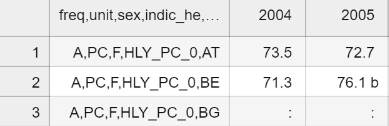
- Choose an appropriate (Multi-)Index.
- Identify:
    1. missing values and get row and column overviews. Use graphical and/or numeric approaches. Once identified, handle missing values according to column type, time series property and data set size.
    2. duplicates (justify the used column subset). Remove duplicates - if any - and inspect what you removed.
- Transform to shape (tidy vs. wide) best suited for further analysis.
- Export the clean data to a file for inspection with an external data browser (e.g., MS Excel).
- Provide an overview of the clean dataset:
    1. show the dtypes
    2. quantitative column descriptions: 
        1. categorical columns: number of unique values, counts 
        2. numeric columns: range and median

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [13]:
# E1:
df = pd.read_csv('Bestand_SC_Alter_Berufswunsch_RGS.csv', sep=';', encoding = 'ISO-8859-1', parse_dates=["Datum"])

df.info(), df['Unnamed: 8'].nunique()
# df['Unnamed 8'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1921893 entries, 0 to 1921892
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Datum              datetime64[ns]
 1   RGSCode            int64         
 2   RGSName            object        
 3   Geschlecht         object        
 4   Altersgruppe       object        
 5   Berufs4Steller     object        
 6   Berufs4StellerBez  object        
 7   BESTAND            int64         
 8   Unnamed: 8         float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 132.0+ MB


(None, 0)

In [14]:
df.drop('Unnamed: 8', axis = 1, inplace = True)
df.head()

,Datum,RGSCode,RGSName,Geschlecht,Altersgruppe,Berufs4Steller,Berufs4StellerBez,BESTAND
0,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,B0254,"Tierzuchtgehilf(en)innen, Tierpfleger/innen",1
1,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,B1761,"Maler/innen, Anstreicher/innen",1
2,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,B2105,"Karosserie-, Kühlerspengler/innen",1
3,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,B2405,Elektromechaniker/innen,1
4,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,B3631,Bäcker/innen,1


In [16]:
df['Geschlecht'] = df['Geschlecht'].astype('category') # only 2 values
df

,Datum,RGSCode,RGSName,Geschlecht,Altersgruppe,Berufs4Steller,Berufs4StellerBez,BESTAND
0,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,B0254,"Tierzuchtgehilf(en)innen, Tierpfleger/innen",1
1,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,B1761,"Maler/innen, Anstreicher/innen",1
2,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,B2105,"Karosserie-, Kühlerspengler/innen",1
3,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,B2405,Elektromechaniker/innen,1
4,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,B3631,Bäcker/innen,1
...,...,...,...,...,...,...,...,...
1921888,2024-08-31,977,Wien Jugendliche II,Männer,25 bis 29 Jahre,B7712,"Laden-, Eintrittskartenkassier(e)innen",2
1921889,2024-08-31,977,Wien Jugendliche II,Männer,25 bis 29 Jahre,B7801,"Industrie-, Gewerbekaufleute (m./w.), Kontoris...",2
1921890,2024-08-31,977,Wien Jugendliche II,Männer,25 bis 29 Jahre,B8081,Nicht diplomierte Krankenpfleger/innen und ver...,3
1921891,2024-08-31,977,Wien Jugendliche II,Männer,25 bis 29 Jahre,B8101,"Fürsorger/innen, Sozialarbeiter/innen",1


In [30]:
#age = df['Altersgruppe'].str.extract(r'(\d+)\s*bis\s*(\d+)', expand=True)
def sep_age(age_range):
    numbers = re.findall(r'\d+', age_range)
    if len(numbers) == 1:
        if age_range.startswith('bis'):
            return pd.Series([0, int(numbers[0])]) # bis 19 Jahre
        else:
            return pd.Series([int(numbers[0]), 99]) # 65 Jahre und älter
    elif len(numbers) == 2:
        # If two numbers, extract both as lower and upper bounds
        return pd.Series([int(numbers[0]), int(numbers[1])])
    return pd.Series([None, None])  # Fallback case (if no match)
 # Fill age_to with the found number
age = df['Altersgruppe'].apply(sep_age)
age

,0,1
0,0,19
1,0,19
2,0,19
3,0,19
4,0,19
...,...,...
1921888,25,29
1921889,25,29
1921890,25,29
1921891,25,29


In [33]:
df['Alter_von'] = age[0]
df['Alter_bis'] = age[1]
df

,Datum,RGSCode,RGSName,Geschlecht,Altersgruppe,Berufs4Steller,Berufs4StellerBez,BESTAND,Alter_von,Alter_bis
0,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,B0254,"Tierzuchtgehilf(en)innen, Tierpfleger/innen",1,0,19
1,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,B1761,"Maler/innen, Anstreicher/innen",1,0,19
2,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,B2105,"Karosserie-, Kühlerspengler/innen",1,0,19
3,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,B2405,Elektromechaniker/innen,1,0,19
4,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,B3631,Bäcker/innen,1,0,19
...,...,...,...,...,...,...,...,...,...,...
1921888,2024-08-31,977,Wien Jugendliche II,Männer,25 bis 29 Jahre,B7712,"Laden-, Eintrittskartenkassier(e)innen",2,25,29
1921889,2024-08-31,977,Wien Jugendliche II,Männer,25 bis 29 Jahre,B7801,"Industrie-, Gewerbekaufleute (m./w.), Kontoris...",2,25,29
1921890,2024-08-31,977,Wien Jugendliche II,Männer,25 bis 29 Jahre,B8081,Nicht diplomierte Krankenpfleger/innen und ver...,3,25,29
1921891,2024-08-31,977,Wien Jugendliche II,Männer,25 bis 29 Jahre,B8101,"Fürsorger/innen, Sozialarbeiter/innen",1,25,29


In [36]:
df['Berufs4Steller'].nunique(), df['Berufs4StellerBez'].nunique()

df['Datum'].value_counts()

Datum
2024-02-29    31869
2021-04-30    31620
2024-04-30    31255
2021-03-31    31234
2024-01-31    30984
              ...  
2020-08-31    24155
2020-06-30    23823
2020-07-31    23536
2020-04-30    23280
2020-05-31    21949
Name: count, Length: 68, dtype: int64

In [37]:
missing_data = df.isnull().sum()
missing_percentages = round((missing_data / len(df)) * 100, 2)

missing_percentages.sort_values(ascending=False)

Berufs4StellerBez    0.03
Datum                0.00
RGSCode              0.00
RGSName              0.00
Altersgruppe         0.00
Geschlecht           0.00
Berufs4Steller       0.00
BESTAND              0.00
Alter_von            0.00
Alter_bis            0.00
dtype: float64

In [41]:
df_nan = df[df['Berufs4StellerBez'].isnull()] # dataset with NaN values (521 rows)
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(1921893, 10)
(1921372, 10)


In [53]:
df_unbest = df[df['Berufs4Steller']=='B9999'] # unbestimmt (nur Pst) ~Personenstammdaten? 
df_missing = pd.concat([df_unbest, df_nan])
print(df_unbest.shape)
print(f"Missing values percentage: {round((len(df_unbest) / len(df)) * 100, 2)}")
df_missing

(23219, 10)
Missing values percentage: 1.21


,Datum,RGSCode,RGSName,Geschlecht,Altersgruppe,Berufs4Steller,Berufs4StellerBez,BESTAND,Alter_von,Alter_bis
13,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,B9999,unbestimmt (nur Pst),1,0,19
110,2019-01-31,101,Eisenstadt,Männer,bis 19 Jahre,B9999,unbestimmt (nur Pst),1,0,19
260,2019-01-31,102,Mattersburg,Männer,bis 19 Jahre,B9999,unbestimmt (nur Pst),2,0,19
394,2019-01-31,103,Neusiedl am See,Männer,30 bis 34 Jahre,B9999,unbestimmt (nur Pst),1,30,34
1173,2019-01-31,202,Hermagor,Frauen,40 bis 44 Jahre,B9999,unbestimmt (nur Pst),1,40,44
...,...,...,...,...,...,...,...,...,...,...
1788158,2024-04-30,501,Bischofshofen,Frauen,35 bis 39 Jahre,B,NaN,1,35,39
1807003,2024-05-31,106,Stegersbach,Männer,bis 19 Jahre,B,NaN,1,0,19
1837679,2024-06-30,108,Stegersbach/Jennersdorf,Männer,bis 19 Jahre,B,NaN,1,0,19
1867228,2024-07-31,108,Stegersbach/Jennersdorf,Männer,bis 19 Jahre,B,NaN,1,0,19


In [56]:
print(df.shape)
df.drop(df[df['Berufs4Steller']=='B9999'].index, inplace=True)
print(df.shape)

(1921372, 10)
(1898153, 10)


In [61]:
print(df[df.duplicated(keep=False)]) # completely duplicated rows
subset = df.columns
subset = subset.drop('BESTAND')
print(df[df.duplicated(subset=subset, keep=False)])

Empty DataFrame
Columns: [Datum, RGSCode, RGSName, Geschlecht, Altersgruppe, Berufs4Steller, Berufs4StellerBez, BESTAND, Alter_von, Alter_bis]
Index: []
Empty DataFrame
Columns: [Datum, RGSCode, RGSName, Geschlecht, Altersgruppe, Berufs4Steller, Berufs4StellerBez, BESTAND, Alter_von, Alter_bis]
Index: []


In [63]:
df.to_csv('clean_data.csv')

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1898153 entries, 0 to 1921892
Data columns (total 10 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Datum              datetime64[ns]
 1   RGSCode            int64         
 2   RGSName            object        
 3   Geschlecht         category      
 4   Altersgruppe       object        
 5   Berufs4Steller     object        
 6   Berufs4StellerBez  object        
 7   BESTAND            int64         
 8   Alter_von          int64         
 9   Alter_bis          int64         
dtypes: category(1), datetime64[ns](1), int64(4), object(4)
memory usage: 146.6+ MB


In [68]:
df['Datum'].min(), df['Datum'].median(), df['Datum'].max(),

(Timestamp('2019-01-31 00:00:00'),
 Timestamp('2021-12-31 00:00:00'),
 Timestamp('2024-08-31 00:00:00'))

In [70]:
print(df['RGSCode'].nunique())
df['RGSCode'].value_counts()

105


RGSCode
964    55830
630    52716
967    52090
965    49220
409    48793
       ...  
505     2486
202     1834
961     1582
613      585
108      544
Name: count, Length: 105, dtype: int64

In [71]:
print(df['RGSName'].nunique())
df['RGSName'].value_counts()

105


RGSName
Wien Favoritenstraße        55830
Graz-West und Umgebung      52716
Wien Huttengasse            52090
Wien Schönbrunner Straße    49220
Linz neu                    48793
                            ...  
Tamsweg                      2486
Hermagor                     1834
Wien Dresdner Straße         1582
Knittelfeld                   585
Stegersbach/Jennersdorf       544
Name: count, Length: 105, dtype: int64

In [72]:
print(df['Geschlecht'].nunique())
df['Geschlecht'].value_counts()

2


Geschlecht
Männer    955470
Frauen    942683
Name: count, dtype: int64

In [73]:
print(df['Altersgruppe'].nunique())
df['Altersgruppe'].value_counts()

11


Altersgruppe
20 bis 24 Jahre       272416
25 bis 29 Jahre       251507
30 bis 34 Jahre       244531
35 bis 39 Jahre       237233
40 bis 44 Jahre       210020
bis 19 Jahre          205797
45 bis 49 Jahre       183434
50 bis 54 Jahre       156802
55 bis 59 Jahre       110821
60 bis 64 Jahre        25048
65 Jahre und älter       544
Name: count, dtype: int64

In [76]:
df['Alter_von'].min(), df['Alter_von'].median(), df['Alter_von'].max()

(np.int64(0), np.float64(30.0), np.int64(65))

In [77]:
df['Alter_bis'].min(), df['Alter_bis'].median(), df['Alter_bis'].max()

(np.int64(19), np.float64(34.0), np.int64(99))

In [74]:
print(df['Berufs4Steller'].nunique())
df['Berufs4Steller'].value_counts()

458


Berufs4Steller
B4018    76632
B3999    75646
B3901    64671
B7801    61537
B7841    61153
         ...  
B2807        1
B2741        1
B2701        1
B6328        1
B1939        1
Name: count, Length: 458, dtype: int64

In [75]:
print(df['Berufs4StellerBez'].nunique())
df['Berufs4StellerBez'].value_counts()

458


Berufs4StellerBez
Sonstige Händler/innen u. Verkäufer/innen                       76632
Hilfsarbeiter/innen (Helfer), soweit nicht anderw. eing.        75646
Warensortierer, -nachseher, -adjustierer, -verpacker (m./w.)    64671
Industrie-, Gewerbekaufleute (m./w.), Kontorist(en)innen        61537
Büroberufe, Verwaltungshilfsberufe                              61153
                                                                ...  
Spuler/innen, Winder/innen, Zwirner/innen                           1
Rauhwarenzurichter/innen, -färber/innen                             1
Gerber/innen, Gerbarbeiter/innen                                    1
Sonstige Techniker/innen für Gärungstechnik                         1
Kessel-, Kupferschmiedhelfer/innen                                  1
Name: count, Length: 458, dtype: int64

In [79]:
print(df['BESTAND'].nunique())
print(df['BESTAND'].min(), df['BESTAND'].median(), df['BESTAND'].max())
df['BESTAND'].value_counts()


456
1 1.0 759


BESTAND
1      1256870
2       287170
3       123057
4        67349
5        40993
        ...   
399          1
246          1
429          1
232          1
406          1
Name: count, Length: 456, dtype: int64

## E2 - Exploratory data analysis (EDA)
Use the clean dataset and understand and explore the relationships in the data (numerical, visual, statistical). This includes at least but is not limited to:
- A comprehensive textual description of meaning for relevant fields in the dataset
- Statistical/numerical descriptions and visualization techniques we learned in the course inluding correlations, distributions and groupings of variing degrees.
- Checks for data quality, e. g., completeness, plausibility, outliers
- Handling any identified problems with the data
- If necessary, use additional data wrangling in line with your EDA and only keep what's necessary for the following steps of your analysis with appropriate data granularity and form ("tidy data")

Don't:
- test/prove hypotheses here. EDA should only motivate hypotheses. 

Advanced/bonus:
- Depending on your hypothesis you may want to join external data (e.g., merge external highest education level to existing vaccination data) for additional insights.

Explain all steps taken and your thinking why you deem them necessary.

Datum

RGSCode

RGSName

Geschlecht

Altersgruppe

Berufs4steller - Code

Berufs4StellerBez

Bestand

Alter_von

Alter_bis

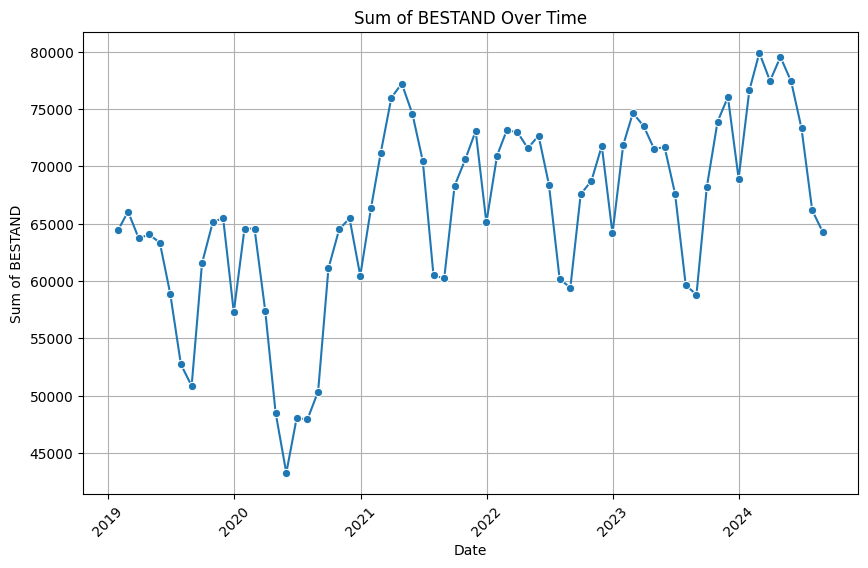

''

In [107]:
# E2:
import seaborn as sns
import matplotlib.pyplot as plt

grouped_data = df.groupby('Datum')['BESTAND'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_data, x='Datum', y='BESTAND', marker='o')

plt.title('Bestandsveränderung 2019 - 2024')
plt.xlabel('Datum')
plt.ylabel('Summe vom BESTAND')
plt.xticks(rotation=45)
plt.grid()
plt.show()

''

#pro jahr groupby(RGSName)[Bestand].sum(), gesamt für alle jahre
#pro jahr groupby(Bezeichnung)[Bestand].sum()
#pro jahr groupby(Geschlecht)[Bestand].sum(), gesamt für alle jahre
#pro jahr groupby(Altersgruppe)[Bestand].sum(), gesamt für alle jahre

#pro jahr groupby(Datum)[Bezeichnung].value_counts(), gesamt für alle jahre
#pro jahr groupby(Geschlecht)[Altersgruppe].value_counts(), gesamt für alle jahre

#top 10 Jobs with most bestand !!!
#Jobs mit wenigstem Bestand



In [82]:
df_zuordnungen = pd.read_excel('24-598_AMS-Berufssystematik_Stand_05-2024.xlsx', dtype=str)
df_zuordnungen


,6-Steller,Berufsbezeichnung,4-St.,Berufsart,3-St.,Berufsgruppe,2-St.,Berufsobergruppe,1-St.,Berufsabteilung
0,010101,Agrarberater/in (DI),0101,"DI (m./w.) für Landwirtschaft, Wein- und Garte...",010,"Techniker/innen f. Landw., landw. Förderungsbe...",01,"Techniker/innen für Landwirtschaft, landwirtsc...",0,Land- und forstwirtschaftliche Berufe
1,010102,Landwirtschaftstechniker/in (DI),0101,"DI (m./w.) für Landwirtschaft, Wein- und Garte...",010,"Techniker/innen f. Landw., landw. Förderungsbe...",01,"Techniker/innen für Landwirtschaft, landwirtsc...",0,Land- und forstwirtschaftliche Berufe
2,010103,Gartenbautechniker/in (DI),0101,"DI (m./w.) für Landwirtschaft, Wein- und Garte...",010,"Techniker/innen f. Landw., landw. Förderungsbe...",01,"Techniker/innen für Landwirtschaft, landwirtsc...",0,Land- und forstwirtschaftliche Berufe
3,010104,Landschaftsplanungs- und Landschaftspflegetech...,0101,"DI (m./w.) für Landwirtschaft, Wein- und Garte...",010,"Techniker/innen f. Landw., landw. Förderungsbe...",01,"Techniker/innen für Landwirtschaft, landwirtsc...",0,Land- und forstwirtschaftliche Berufe
4,010105,Getreidebautechniker/in (DI),0101,"DI (m./w.) für Landwirtschaft, Wein- und Garte...",010,"Techniker/innen f. Landw., landw. Förderungsbe...",01,"Techniker/innen für Landwirtschaft, landwirtsc...",0,Land- und forstwirtschaftliche Berufe
...,...,...,...,...,...,...,...,...,...,...
4324,571114,Fußpfleger/in (Podolog(e)in),5711,"Kosmetiker/innen, Hand-, Fußpfleger/innen",571,"Kosmetiker/innen, Hand-, Fußpfleger/innen",57,"Friseur(e)innen, Schönheitspfleger/innen und v...",5,Dienstleistungsberufe
4325,571115,Kosmetiker/in (Kosmetolog(e)in),5711,"Kosmetiker/innen, Hand-, Fußpfleger/innen",571,"Kosmetiker/innen, Hand-, Fußpfleger/innen",57,"Friseur(e)innen, Schönheitspfleger/innen und v...",5,Dienstleistungsberufe
4326,571183,Kosmetiker/in (Kosmetolog(e)in)/Fußpfleger/in ...,5711,"Kosmetiker/innen, Hand-, Fußpfleger/innen",571,"Kosmetiker/innen, Hand-, Fußpfleger/innen",57,"Friseur(e)innen, Schönheitspfleger/innen und v...",5,Dienstleistungsberufe
4327,571116,Kosmetiker/in (Kosmetolog(e)in)/Fußpfleger/in ...,5711,"Kosmetiker/innen, Hand-, Fußpfleger/innen",571,"Kosmetiker/innen, Hand-, Fußpfleger/innen",57,"Friseur(e)innen, Schönheitspfleger/innen und v...",5,Dienstleistungsberufe


In [83]:
df_zuordnungen['1-St.'].nunique(), df_zuordnungen['2-St.'].nunique()
#print(df_zuordnungen['Berufsabteilung'].nunique()) # 7 verschiedene da Stufe 1,2,3 gleich sind
#print(df_zuordnungen['Berufsobergruppe'].nunique())

(9, 76)

In [85]:
df['Berufs4Steller'] = df['Berufs4Steller'].replace('B', '', regex=True)
df

,Datum,RGSCode,RGSName,Geschlecht,Altersgruppe,Berufs4Steller,Berufs4StellerBez,BESTAND,Alter_von,Alter_bis
0,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,0254,"Tierzuchtgehilf(en)innen, Tierpfleger/innen",1,0,19
1,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,1761,"Maler/innen, Anstreicher/innen",1,0,19
2,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,2105,"Karosserie-, Kühlerspengler/innen",1,0,19
3,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,2405,Elektromechaniker/innen,1,0,19
4,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,3631,Bäcker/innen,1,0,19
...,...,...,...,...,...,...,...,...,...,...
1921888,2024-08-31,977,Wien Jugendliche II,Männer,25 bis 29 Jahre,7712,"Laden-, Eintrittskartenkassier(e)innen",2,25,29
1921889,2024-08-31,977,Wien Jugendliche II,Männer,25 bis 29 Jahre,7801,"Industrie-, Gewerbekaufleute (m./w.), Kontoris...",2,25,29
1921890,2024-08-31,977,Wien Jugendliche II,Männer,25 bis 29 Jahre,8081,Nicht diplomierte Krankenpfleger/innen und ver...,3,25,29
1921891,2024-08-31,977,Wien Jugendliche II,Männer,25 bis 29 Jahre,8101,"Fürsorger/innen, Sozialarbeiter/innen",1,25,29


In [98]:
df_zuordnungen_small = df_zuordnungen[['4-St.', 'Berufsobergruppe']].drop_duplicates()
merged_df = df.merge(df_zuordnungen_small, left_on='Berufs4Steller', right_on='4-St.', how='inner')
#df_zuordnungen_small
merged_df

,Datum,RGSCode,RGSName,Geschlecht,Altersgruppe,Berufs4Steller,Berufs4StellerBez,BESTAND,Alter_von,Alter_bis,4-St.,Berufsobergruppe
0,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,0254,"Tierzuchtgehilf(en)innen, Tierpfleger/innen",1,0,19,0254,"Ackerbau-, Tierzucht-, Gartenbauberufe"
1,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,1761,"Maler/innen, Anstreicher/innen",1,0,19,1761,Bauberufe
2,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,2105,"Karosserie-, Kühlerspengler/innen",1,0,19,2105,"Spengler/innen, Rohrinstallateur(e)innen, Meta..."
3,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,2405,Elektromechaniker/innen,1,0,19,2405,Elektriker/innen
4,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,3631,Bäcker/innen,1,0,19,3631,Nahrungs- und Genußmittelhersteller/innen
...,...,...,...,...,...,...,...,...,...,...,...,...
1898148,2024-08-31,977,Wien Jugendliche II,Männer,25 bis 29 Jahre,7712,"Laden-, Eintrittskartenkassier(e)innen",2,25,29,7712,"Buchhalter/innen, Kassier(e)innen und verwandt..."
1898149,2024-08-31,977,Wien Jugendliche II,Männer,25 bis 29 Jahre,7801,"Industrie-, Gewerbekaufleute (m./w.), Kontoris...",2,25,29,7801,"Übrige Büroberufe, Verwaltungshilfsberufe"
1898150,2024-08-31,977,Wien Jugendliche II,Männer,25 bis 29 Jahre,8081,Nicht diplomierte Krankenpfleger/innen und ver...,3,25,29,8081,Gesundheitsberufe
1898151,2024-08-31,977,Wien Jugendliche II,Männer,25 bis 29 Jahre,8101,"Fürsorger/innen, Sozialarbeiter/innen",1,25,29,8101,"Fürsorger/innen, Sozialarbeiter/innen"


In [99]:
# https://www.ams.at/content/dam/download/allgemeine-informationen/001_amd-online_verzeichnis_arbeitsmarktbezirke.pdf
bundesland_mapping = {
    '1': 'Burgenland',
    '2': 'Kärnten',
    '3': 'Niederösterreich',
    '4': 'Oberösterreich',
    '5': 'Salzburg',
    '6': 'Steiermark',
    '7': 'Tirol',
    '8': 'Vorarlberg',
    '9': 'Wien'
}

# extract first character of RGSCode and map to Bundesland
merged_df['Bundesland'] = merged_df['RGSCode'].astype(str).str[0].map(bundesland_mapping)

In [102]:
merged_df.drop('4-St.', axis=1, inplace=True)


KeyError: "['4-St.'] not found in axis"

In [103]:
missing_data = merged_df.isnull().sum()
missing_percentages = round((missing_data / len(merged_df)) * 100, 2)

missing_percentages.sort_values(ascending=False)

Datum                0.0
RGSCode              0.0
RGSName              0.0
Geschlecht           0.0
Altersgruppe         0.0
Berufs4Steller       0.0
Berufs4StellerBez    0.0
BESTAND              0.0
Alter_von            0.0
Alter_bis            0.0
Berufsobergruppe     0.0
Bundesland           0.0
dtype: float64

In [104]:
merged_df.to_csv('merged_data.csv')
merged_df

,Datum,RGSCode,RGSName,Geschlecht,Altersgruppe,Berufs4Steller,Berufs4StellerBez,BESTAND,Alter_von,Alter_bis,Berufsobergruppe,Bundesland
0,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,0254,"Tierzuchtgehilf(en)innen, Tierpfleger/innen",1,0,19,"Ackerbau-, Tierzucht-, Gartenbauberufe",Burgenland
1,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,1761,"Maler/innen, Anstreicher/innen",1,0,19,Bauberufe,Burgenland
2,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,2105,"Karosserie-, Kühlerspengler/innen",1,0,19,"Spengler/innen, Rohrinstallateur(e)innen, Meta...",Burgenland
3,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,2405,Elektromechaniker/innen,1,0,19,Elektriker/innen,Burgenland
4,2019-01-31,101,Eisenstadt,Frauen,bis 19 Jahre,3631,Bäcker/innen,1,0,19,Nahrungs- und Genußmittelhersteller/innen,Burgenland
...,...,...,...,...,...,...,...,...,...,...,...,...
1898148,2024-08-31,977,Wien Jugendliche II,Männer,25 bis 29 Jahre,7712,"Laden-, Eintrittskartenkassier(e)innen",2,25,29,"Buchhalter/innen, Kassier(e)innen und verwandt...",Wien
1898149,2024-08-31,977,Wien Jugendliche II,Männer,25 bis 29 Jahre,7801,"Industrie-, Gewerbekaufleute (m./w.), Kontoris...",2,25,29,"Übrige Büroberufe, Verwaltungshilfsberufe",Wien
1898150,2024-08-31,977,Wien Jugendliche II,Männer,25 bis 29 Jahre,8081,Nicht diplomierte Krankenpfleger/innen und ver...,3,25,29,Gesundheitsberufe,Wien
1898151,2024-08-31,977,Wien Jugendliche II,Männer,25 bis 29 Jahre,8101,"Fürsorger/innen, Sozialarbeiter/innen",1,25,29,"Fürsorger/innen, Sozialarbeiter/innen",Wien


## E3 - Formulate hypotheses

*Note: Read this section entirely and understand it - every group member.*

A hypothesis is an idea or explanation for something that is based on known facts but has not yet been proved. A hypothesis is a compact, concise statement, such as: "Individuals with higher income have (on average) more offspring.", that will be answered based on facts (the data). https://gradcoach.com/what-is-a-research-hypothesis-or-scientific-hypothesis/

Formulate *N* non-trivial hypotheses, 1 per group member, and regard the following criteria: 
- State the hypothesis explicitly in concise language. 
- The hypothesis must be **motivated** by either **EDA results** or **literature** (citation in the report needed).
- The hypothesis must refer to **endpoints** that are **testable**. Specifically, the endpoint must be derived from the data.
- Think of real-life use cases/consequences of your results (textual description). 
- For each hypothesis explain all executed steps. 
- In case of extreme or implausible results check the validity of your data.
- For each hypothesis export the artifacts (figures, tables, etc.) required for the report.
- If you decide to use a statistical test, use it properly. In particular, check the validity and comparability of the samples.

Do not:
- State nebulous, vague hypotheses. These don't contain endpoints and are unclear to test (i.e., answer).
- Use post-hoc hypotheses. Portraying an empirically inspired **post hoc hypothesis as a priori** violates the **falsification principle** crucial for hypothesis-driven (that is, confirmatory) empirical research. Falsification is severe scientific fraud.
- State trivial hypotheses (e.g., hypthesis 2: "Not Hypothesis 1").
- Answer based on "common knowledge".
- Try to **produce positively tested hypotheses**. If a well motivated hypothesis is negative, this is an important finding (see Simpson's Paradox). The value of a tested hypothesis lies in the information or learning it provides.

Example: The homework with Simpson's Paradox. The pooled overall comparison between the genders would be the EDA motivating the hypothesis: "At UC Berkeley the by-department admissions rate for females is lower than for males." It should be tested using samples of department admission rates for the 2 **groups** male and female. No steps of the test should be done in EDA (or a priory to stating the hypothesis). The groups should be compared graphically, e.g., via a stripplot overlayed with a boxplot. The figure should be labelled properly and exported for the report. A (paired) t-test **may** be used (it's optional) to test this hypothesis statistically. For different data (e.g., time series) different approaches may be required. You don't have to use statistical tests, in particular if you don't know what they are doing.


### E3-H1: "xxx"
Author: Group member 1


In [ ]:
# hypothesen:
# Anzahl der Frauen, die Ausb. im Bereich Technik machen, ist von 2019 bis 2024 signifikant angestiegen
# Anzahl der Frauen, die Ausb. im Bereich Technik machen, ist in Wien (und Graz) signifikant höher als im Rest Österreichs

### E3-H2: "xxx"
Author: Group member 2



### E3-H3: "xxx"
Author: Group member 3


### E3-H4: "xxx"
Author: Group member 4


### E3-H5: "xxx"
Author: Group member 5
